In [15]:
import numpy as np
import mygrad as mg
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from mygrad.computational_graph import build_graph

from rich.progress import Progress, TextColumn, BarColumn, TimeElapsedColumn, track
from rich import print

import Layers
import optimisers
import activations
import models


ImportError: attempted relative import with no known parent package

In [3]:

print("[bold yellow]Libraries are imported loading data[/bold yellow]")
df = pd.read_csv("K:/Redmi 9e/Data Analysis/MNIST Digits/train.csv")
print("[bold yellow]Data loaded[/bold yellow]")
train, test = train_test_split(df, test_size=0.2)

# OneHotEncoder is not needed if we use softmax_crossentropy correctly
# encoder = OneHotEncoder(sparse_output=False)
# encoder.fit(df["label"].values.reshape(-1, 1))

# FIX 1: The final layer should have `activation=None` because softmax_crossentropy
# applies the softmax internally for better numerical stability.
lr1 = Layers.Dense(784, 128, activation=activations.ReLU, use_bias=True)
lr2 = Layers.Dense(128, 10, activation=(lambda x: x), use_bias=True) # Changed from 100 -> 10, no activation
model = models.Sequental([lr1, lr2]) # Simplified model for faster demonstration

optim = optimisers.SGD(0.1, 0.01)
print(f"[bold yellow]Layers initiated and connected successfully[/]")

def batch_gen(df, batch_size):
    for start in range(0, len(df), batch_size):
        end = start + batch_size
        yield df.iloc[start:end]


Libraries are imported loading data

Data loaded

NameError: name 'Layers' is not defined

In [ ]:

print("[bold red on yellow]The Training has started[/]")

loss_history = []
batch_len = 64
epochs = 5

for i in range(epochs):
    # FIX 2: Correct total for the progress bar
    for batch in track(batch_gen(train, batch_len), description=f"Training Epoch {i+1}/{epochs}...",
                       total=len(train)//batch_len):
        x = mg.tensor(batch.drop(columns="label").values.astype(np.float32) / 255)
        
        # FIX 3: softmax_crossentropy expects integer class labels, not one-hot encoded vectors.
        y_true = batch["label"].values
        
        # Forward pass produces logits (raw scores)
        logits = model.forward(x)
        
        # The loss function takes logits and integer labels
        loss_value = mg.nnet.losses.softmax_crossentropy(logits, y_true)
        
        loss_history.append(loss_value.data.item())
        
        loss_value.backward()
        optim.optimise(model)
        # Clear grads for the next iteration
        model.null_grads() 

    # Evaluate loss on the last batch of the epoch
    print(f"[bold green]Epoch {i+1} trained successfully with final batch loss [/bold green]"
          f"[bold white]{loss_value.data.item():.4f}[/bold white]")


The Training has started

Output()

Epoch 1 trained successfully with final batch loss 17.7234

Output()

Epoch 2 trained successfully with final batch loss 4.0682

Output()

Epoch 3 trained successfully with final batch loss 3.0904

Output()

Epoch 4 trained successfully with final batch loss 3.4373

Output()

Epoch 5 trained successfully with final batch loss 2.0797

 Final Test Accuracy: 85.55% 🎉

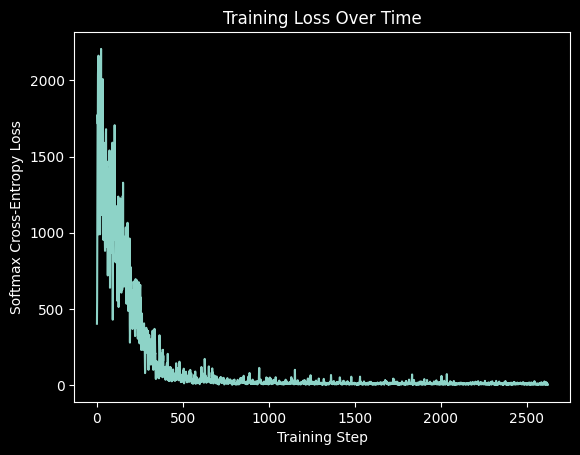

In [ ]:

# After training, get predictions on the test set
test_x = mg.tensor(test.drop(columns="label").values.astype(np.float32) / 255)
# Pass through the model to get logits
test_logits = model.forward(test_x)
# The predicted class is the index of the highest score (argmax)
predictions = np.argmax(test_logits.data, axis=1)

accuracy = (test["label"].values == predictions).mean()

print(f"[bold purple] Final Test Accuracy: {accuracy:.2%} :tada:[/]")

plt.plot(loss_history)
plt.title("Training Loss Over Time")
plt.xlabel("Training Step")
plt.ylabel("Softmax Cross-Entropy Loss")
plt.show()
# Final Test Accuracy: 85.55% 🎉

In [ ]:
def sample_and_test(model: models.Sequental, data: pd.DataFrame):
    sample = data.sample(1, replace=True)
    prediction = model.forward(sample.drop(columns="label"))
    prediction = activations.softmax(prediction)
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(sample.drop(columns="label").values.reshape(28, 28))
    ax[0].grid(False)

    ax[1].grid(False)
    ax[1].barh(np.array(list(range(0, 10))), prediction.flatten())

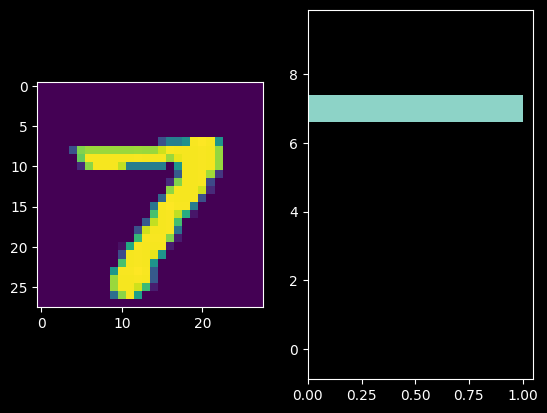

In [ ]:
sample_and_test(model, test)